# PROJECT NAME: Compare Q-Learning and MiniMax(Alpha/Beta) in Tic-Tac-Toe

# **Project Workflow**




1. **Introduction**
    * Purpose: Briefly describe the project purpose (e.g., comparing reinforcement learning and planning/searching algorithms for game playing).
    * Algorithms: Introduce the algorithms you'll implement and compare (e.g., Q-learning, DQN, Minimax, Alpha-beta, MCTS, Random).
    * Game: Mention the game you chose for evaluation (e.g., Tic-Tac-Toe or another game).

2. **Import Libraries**
    * Import necessary libraries like numpy, matplotlib, tensorflow.

3. **Experimental Methods**
    * Workflow
    * Game Setup: Define Tic-Tac-Toe game environment
    * Evaluation Metrix  (win rate, average reward, training time,convergence rate, and decision time)

4. **Implement Random Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Random will serve as a baseline

5. **Implement Minimax Algorithms**
    * Algorithms Description
    * Parameters Analysis (Set the parameters planned to vary)
    * Conclusion(Analyze how changing parameters impacted the agents' performance)
    
6. **Implement Alpha-beta Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Conclusion

7. **Implement MCTS Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Conclusion

8. **Implement Q-learning Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Conclusion

9. **Implement DQN Algorithms**
    * Algorithms Description
    * Parameters Analysis
    * Conclusion


10. **Discussion and Analysis**
    * Visual Performance Comparison (Use graphs and tables to compare the performance of different algorithms. Show win rates, decision time, and convergence rate.)
    * Compare the strengths and weaknesses of RL (e.g., Q-learning, DQN) vs. planning algorithms (Minimax, MCTS).

11. **Conclusion**
    * Summarize the key findings and suggest potential improvements or future work

12. **References**


# **Step1: Introduction**

# **Step 2. Import Libraries**



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output

from tqdm import tqdm
import pickle, math, logging, random, time
import pandas as pd


# **Step 3. Experimental Methods**


## 3.1 Workflow

## 3.2 Game Setup
 Define Tic-Tac-Toe game environment

In [ ]:
ROWS, COLS = 3, 3

name = 'qlvsran'
logger = logging.getLogger(name)
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(f'{name}.log')
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)


class Board:
    def __init__(self, dimensions=(3, 3)):
        self.dimensions = dimensions
        self.board = np.zeros(self.dimensions, dtype=int)
        self.turn = 1  # Player 1 starts

    def copy(self):
        new_board = Board(self.dimensions)
        new_board.board = np.copy(self.board)
        new_board.turn = self.turn
        return new_board

    def possible_moves(self):
        # Returns a list of positions where the board is empty
        positions = np.argwhere(self.board == 0)
        return positions

    def push(self, action):
        # Makes a move on the board
        action = tuple(action)
        if self.board[action] == 0:
            self.board[action] = self.turn
            # Switch turn
            self.turn = 2 if self.turn == 1 else 1
        else:
            raise ValueError('Invalid move: Position already taken')

    def result(self):
        # Checks for a winner or a draw
        for i in range(3):
            # Check rows
            if np.all(self.board[i, :] == 1):
                return 1
            if np.all(self.board[i, :] == 2):
                return 2
            # Check columns
            if np.all(self.board[:, i] == 1):
                return 1
            if np.all(self.board[:, i] == 2):
                return 2
        # Check diagonals
        if np.all(np.diag(self.board) == 1):
            return 1
        if np.all(np.diag(self.board) == 2):
            return 2
        if np.all(np.diag(np.fliplr(self.board)) == 1):
            return 1
        if np.all(np.diag(np.fliplr(self.board)) == 2):
            return 2
        # Check for a draw
        if np.all(self.board != 0):
            return 0  # Draw
        # Game is still ongoing
        return None

    def get_mark_at_position(self, position):
        # Returns the mark at the given position
        position = tuple(position)
        return self.board[position]

    def set_mark(self, position, player):
        # Sets the mark at the given position for the specified player
        position = tuple(position)
        if self.board[position] == 0:
            self.board[position] = player
        else:
            raise ValueError('Invalid move: Position already taken')


class TicTacToe:
    def __init__(self, p1, p2):
        self.board = Board(dimensions=(ROWS, COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None

    def getBoard(self):
        self.boardHash = str(self.board.board.flatten())
        return self.boardHash

    def getWinner(self):
        return self.board.result()

    def getPositions(self):
        return self.board.possible_moves()

    def setReward(self):
        result = self.getWinner()
        if result == 1:
            self.p1.setReward(1)  # Player 1 wins
            self.p2.setReward(0)  # Player 2 loses
        elif result == 2:
            self.p1.setReward(0)  # Player 1 loses
            self.p2.setReward(1)  # Player 2 wins
        else:
            # In case of a draw or the game is still ongoing
            self.p1.setReward(0.2)  # Draw reward for Player 1
            self.p2.setReward(0.2)

    def reset(self):
        self.board = Board()
        self.boardHash = None
        self.isEnd = False

    def setMove(self, action):
        self.board.push(action)

    def train(self, rounds=1000):

        for i in tqdm(range(rounds)):

            while not self.isEnd:
                positions = self.getPositions()
                p1_action = self.p1.getMove(positions, self.board)
                self.setMove(p1_action)
                board_hash = self.getBoard()
                self.p1.setState(board_hash)

                win = self.getWinner()
                if win is not None:
                    self.setReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    self.setReward()
                    positions = self.getPositions()
                    p2_action = self.p2.getMove(positions, self.board)
                    self.setMove(p2_action)
                    board_hash = self.getBoard()
                    self.p2.setState(board_hash)

                    win = self.getWinner()
                    if win is not None:
                        self.setReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break




    def update_stats(self, winner, move_count, p1_decision_time, p2_decision_time, stats):

        if stats is None:
            return

        if winner == self.p1.name:
            stats['p1_wins'] += 1
            stats['p1_rewards'].append(1)
            stats['p2_rewards'].append(0)
        elif winner == self.p2.name:
            stats['p2_wins'] += 1
            stats['p1_rewards'].append(0)
            stats['p2_rewards'].append(1)
        else:
            stats['draws'] += 1
            stats['p1_rewards'].append(0.2)
            stats['p2_rewards'].append(0.2)

        stats['moves'].append(move_count)
        stats['p1_times'].append(p1_decision_time)
        stats['p2_times'].append(p2_decision_time)

    def handle_win(self, winner, check):
        if check:
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.text(0.5, 0.5, f"{winner} wins!", fontsize=30, ha='center', va='center')
            plt.axis('off')
            plt.show()
        logger.warning(f"{winner}")
        self.reset()
        return winner

    def handle_draw(self, check):
        if check:
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.text(0.5, 0.5, "Tie Game", fontsize=30, ha='center', va='center')
            plt.axis('off')
            plt.show()
        logger.warning("tie")
        self.reset()
        return "tie"

    def play(self, check=False, stats=None):
        move_count = 0
        p1_decision_time = 0
        p2_decision_time = 0

        while not self.isEnd:
            # Player 1's move
            start_time = time.time()
            positions = self.getPositions()
            p1_action = self.p1.getMove(positions, self.board)
            self.setMove(p1_action)
            move_count += 1
            p1_decision_time += (time.time() - start_time) * 1000  # Record decision time in ms

            clear_output()
            if check:
                self.showBoard(self.p1.name)

            win = self.getWinner()
            if win is not None:
                if win == 1:
                    winner = self.p1.name
                    self.update_stats(winner, move_count, p1_decision_time, p2_decision_time, stats)
                    return self.handle_win(winner, check)
                else:
                    self.update_stats("tie", move_count, p1_decision_time, p2_decision_time, stats)
                    return self.handle_draw(check)

            # Player 2's move
            start_time = time.time()
            positions = self.getPositions()
            p2_action = self.p2.getMove(positions, self.board)
            self.setMove(p2_action)
            move_count += 1
            p2_decision_time += (time.time() - start_time) * 1000  # Record decision time in ms

            clear_output()
            if check:
                self.showBoard(self.p2.name)

            win = self.getWinner()
            if win is not None:
                if win == 2:
                    winner = self.p2.name
                    self.update_stats(winner, move_count, p1_decision_time, p2_decision_time, stats)
                    return self.handle_win(winner, check)
                else:
                    self.update_stats("tie", move_count, p1_decision_time, p2_decision_time, stats)
                    return self.handle_draw(check)

    def evaluate(self, rounds=100, check=False):
        stats = {
            'p1_wins': 0,
            'p2_wins': 0,
            'draws': 0,
            'p1_rewards': [],
            'p2_rewards': [],
            'moves': [],
            'p1_times': [],
            'p2_times': []
        }

        for _ in range(rounds):
            self.play(check=check, stats=stats)

        # Calculate statistics
        win_rate_p1 = (stats['p1_wins'] / rounds) * 100
        win_rate_p2 = (stats['p2_wins'] / rounds) * 100
        draw_rate = (stats['draws'] / rounds) * 100
        avg_reward_p1 = np.mean(stats['p1_rewards'])
        avg_reward_p2 = np.mean(stats['p2_rewards'])
        reward_p1 = np.sum(stats['p1_rewards'])
        reward_p2 = np.sum(stats['p2_rewards'])
        avg_moves = np.mean(stats['moves'])
        avg_decision_time_p1 = np.mean(stats['p1_times'])
        avg_decision_time_p2 = np.mean(stats['p2_times'])
        variance_of_returns_p1 = np.var(stats['p1_rewards'])
        variance_of_returns_p2 = np.var(stats['p2_rewards'])

        return {
            "Win Rate P1 (%)": win_rate_p1,
            "Win Rate P2 (%)": win_rate_p2,
            "Draw Rate (%)": draw_rate,
            "Avg Reward P1": avg_reward_p1,
            "Avg Reward P2": avg_reward_p2,
            "Reward P1": reward_p1,
            "Reward P2": reward_p2,
            "Avg Moves": avg_moves,
            "Avg Decision Time P1 (ms)": avg_decision_time_p1,
            "Avg Decision Time P2 (ms)": avg_decision_time_p2,
            "Variance of Returns P1": variance_of_returns_p1,
            "Variance of Returns P2": variance_of_returns_p2
        }


    def plotBoard(self,name):

        # Define the symbols for players
        symbols = {1: 'X', 2: 'O'}

        # Create a new figure with defined figure size and square subplots
        fig, ax = plt.subplots(figsize=(7, 7))

        # Set the aspect of the plot to be equal
        ax.set_aspect('equal')

        # Plot the board with player symbols
        for i in range(3):
            for j in range(3):
                # Add player symbol to the corresponding cell
                # Note: the origin is at the top-left corner for the Tic-Tac-Toe board
                player = self.board.get_mark_at_position((i, j))
                symbol = symbols.get(player, ' ')
                color = 'red' if symbol == 'O' else 'black'
                ax.text(j + 0.5, 2.5 - i, symbol, ha='center', va='center', fontsize=50, color=color, family='monospace')
                # ax.text(j + 0.5, 2.5 - i, symbol, ha='center', va='center', fontsize=50, family='monospace')

        # Draw grid lines
        for x in range(1, 3):
            ax.axvline(x=x, color='black', linestyle='-', linewidth=2)
        for y in range(1, 3):
            ax.axhline(y=y, color='black', linestyle='-', linewidth=2)

        # Set limits to just beyond the grid
        ax.set_xlim(0, 3)
        ax.set_ylim(0, 3)

        # Remove axis ticks and labels
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        plt.title(f"{name} played the Turn")
        # plt.show()
        plt.show(block=False)  # Set block=False to ensure non-blocking behavior
        plt.pause(0.8)  # Display the plot for 0.5 seconds
        plt.close()


    def showBoard(self,name):
        self.plotBoard(name)



class RandomPlayer:
    def __init__(self, name='random'):
        self.name = name

    def getMove(self, positions, board):
        # Selects a random move from the list of possible moves
        return random.choice(positions)

    def setReward(self, reward):
        pass

    def setState(self, state):
        pass

    def reset(self):
        pass


class MinimaxPlayer:
    def __init__(self, name='minimax', use_alpha_beta=True, max_depth=5):
        self.name = name
        self.use_alpha_beta = use_alpha_beta  # 是否启用 alpha-beta 剪枝
        self.max_depth = max_depth  # 最大搜索深度

    def getMove(self, positions, board):
        # 检查是否是空棋盘，如果是，随机选择一个位置
        if len(positions) == 9:  # 初始状态，9个空位，说明棋盘为空
            return random.choice(positions)

        best_move = None
        best_score = -float('inf') if board.turn == 1 else float('inf')

        for move in positions:
            new_board = board.copy()
            new_board.push(move)

            if self.use_alpha_beta:
                score = self.minimax(new_board, board.turn == 2, 0, -float('inf'), float('inf'))
            else:
                score = self.minimax(new_board, board.turn == 2, 0)

            if board.turn == 1:  # Maximizing player
                if score > best_score:
                    best_score = score
                    best_move = move
            else:  # Minimizing player
                if score < best_score:
                    best_score = score
                    best_move = move

        return best_move

    def minimax(self, board, is_maximizing, depth, alpha=None, beta=None):
        result = board.result()

        if result is not None or depth >= self.max_depth:
            return self.get_score(result)

        if is_maximizing:
            best_score = -float('inf')
            for move in board.possible_moves():
                new_board = board.copy()
                new_board.push(move)
                score = self.minimax(new_board, False, depth + 1, alpha, beta)
                best_score = max(best_score, score)

                if self.use_alpha_beta:
                    alpha = max(alpha, best_score)
                    if beta is not None and beta <= alpha:  # Beta剪枝
                        break
            return best_score
        else:
            best_score = float('inf')
            for move in board.possible_moves():
                new_board = board.copy()
                new_board.push(move)
                score = self.minimax(new_board, True, depth + 1, alpha, beta)
                best_score = min(best_score, score)

                if self.use_alpha_beta:
                    beta = min(beta, best_score)
                    if alpha is not None and beta <= alpha:  # Alpha剪枝
                        break
            return best_score

    def get_score(self, result):
        if result == 1:
            return 10  # Player 1 wins, positive score
        elif result == 2:
            return -10  # Player 2 wins, negative score
        else:
            return 0  # Draw or ongoing game

    def setReward(self, reward):
        pass

    def setState(self, state):
        pass

    def reset(self):
        pass




class QLearningPlayer:
    def __init__(self, name='q-agent', alpha=0.6, epsilon=0.3, gamma=0.95):
        self.name = name
        self.states = []
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q_table = {}
        self.q_value_changes = []  # 用来存储 Q 值的变化量

    def getHash(self, board):
        # Simplify the hash generation process
        return str(board.board.flatten())

    def getMove(self, positions, current_board):
        # Decide between exploration and exploitation
        if np.random.uniform(0, 1) <= self.epsilon:
            # Exploration: Random move
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            # Exploitation: Choose the best move based on Q values
            action = self._choose_best_action(positions, current_board)
        return action

    def _choose_best_action(self, positions, current_board):
        maxValue = -999
        for p in positions:
            nextBoard = current_board.copy()
            nextBoard.push(tuple(p))
            nextBoardState = self.getHash(nextBoard)
            value = self.Q_table.get(nextBoardState, 0)  # Use a default value of 0
            if value > maxValue:
                maxValue = value
                action = p
        return action

    def setState(self, state):
        # Append state to states list
        self.states.append(state)

    def setReward(self, reward):
        # Traverse the states in reverse to update Q values
        for st in reversed(self.states):
            if st not in self.Q_table:
                self.Q_table[st] = 0
            prev_value = self.Q_table[st]  # 存储旧的 Q 值
            #self.Q_table[st] += self.alpha * (reward + self.gamma * self.Q_table[st] - self.Q_table[st]) # 更像标准的 Q-learning 更新公式，适合当你希望模型既关注当前奖励，又考虑未来奖励时。
            self.Q_table[st] += self.alpha * (self.gamma * reward - self.Q_table[st]) #只使用了当前奖励，适合只关注即时奖励或奖励衰减得很快的场景

            # 计算 Q 值变化并存储
            q_value_delta = abs(self.Q_table[st] - prev_value)
            self.q_value_changes.append(q_value_delta)

            reward = self.Q_table[st]

    def getQValueChanges(self):
        # 返回 Q 值变化的记录
        return self.q_value_changes

    def resetQValueChanges(self):
        # 重置 Q 值变化的记录
        self.q_value_changes = []

    def reset(self):
        # Reset the states list
        self.states = []

    def savePolicy(self):
        # Save the Q-table to a file
        filename = 'policy_' + str(self.name)
        print('Saving Policy: ' + str(filename))
        with open(filename, 'wb') as fw:
            pickle.dump(self.Q_table, fw)

    def loadPolicy(self, file):
        # Load a Q-table from a file
        with open(file, 'rb') as fr:
            self.Q_table = pickle.load(fr)

In [ ]:
# Example of usage
random_player_1 = RandomPlayer(name="random1")
random_player_2 = RandomPlayer(name="random2")

# RandomPlayer vs RandomPlayer (10 rounds)
ttt = TicTacToe(random_player_1, random_player_2)
results_random_vs_random = ttt.evaluate(rounds=10)
print("RandomPlayer vs RandomPlayer:", results_random_vs_random)


# Convert results to a DataFrame and display as a table
df_results = pd.DataFrame([results_random_vs_random])
df_results.columns = ['Win Rate P1 (%)', 'Win Rate P2 (%)', 'Draw Rate (%)',
                      'Avg Reward P1', 'Avg Reward P2','Reward P1', 'Reward P2', 'Avg Moves',
                      'Avg Decision Time P1 (ms)', 'Avg Decision Time P2 (ms)',
                      'Variance of Returns P1', 'Variance of Returns P2']
df_results.index = ['RandomPlayer vs RandomPlayer']

print("Results of RandomPlayer vs RandomPlayer:")
df_results

RandomPlayer vs RandomPlayer: {'Win Rate P1 (%)': 50.0, 'Win Rate P2 (%)': 10.0, 'Draw Rate (%)': 40.0, 'Avg Reward P1': 0.58, 'Avg Reward P2': 0.18, 'Reward P1': 5.8, 'Reward P2': 1.8, 'Avg Moves': 8.1, 'Avg Decision Time P1 (ms)': 0.4328727722167969, 'Avg Decision Time P2 (ms)': 0.28388500213623047, 'Variance of Returns P1': 0.1796, 'Variance of Returns P2': 0.08360000000000001}
Results of RandomPlayer vs RandomPlayer:


,Win Rate P1 (%),Win Rate P2 (%),Draw Rate (%),Avg Reward P1,Avg Reward P2,Reward P1,Reward P2,Avg Moves,Avg Decision Time P1 (ms),Avg Decision Time P2 (ms),Variance of Returns P1,Variance of Returns P2
RandomPlayer vs RandomPlayer,50.0,10.0,40.0,0.58,0.18,5.8,1.8,8.1,0.432873,0.283885,0.1796,0.0836


In [ ]:
if 1==2 :
  minimax_player1 = MinimaxPlayer(name=f"minimax_pruning_depth1", use_alpha_beta=True, max_depth=1)
  minimax_player3 = MinimaxPlayer(name=f"minimax_pruning_depth3", use_alpha_beta=True, max_depth=3)
  minimax_player9 = MinimaxPlayer(name=f"minimax_pruning_depth9", use_alpha_beta=True, max_depth=9)
  ttt = TicTacToe(minimax_player3, minimax_player9)
  ttt.play(check=True)

In [ ]:
if 1==2 :
  # Run experiments with different parameters
  results = []

  # Case 1: Minimax without Alpha-Beta Pruning
  minimax_player = MinimaxPlayer(name="minimax_no_pruning", use_alpha_beta=False)
  ttt = TicTacToe(minimax_player, random_player_1)
  results_minimax_no_pruning = ttt.evaluate(rounds=10)
  results.append({
      'Depth': 'No Pruning',  # Make sure this is a string
      'Win Rate P1 (%)': results_minimax_no_pruning['Win Rate P1 (%)'],
      'Draw Rate (%)': results_minimax_no_pruning['Draw Rate (%)'],
      'Avg Reward P1': results_minimax_no_pruning['Avg Reward P1'],
      'Avg Moves': results_minimax_no_pruning['Avg Moves'],
      'Avg Decision Time P1 (ms)': results_minimax_no_pruning['Avg Decision Time P1 (ms)'],
      'Variance of Returns P1': results_minimax_no_pruning['Variance of Returns P1']
  })

  # Case 2: Minimax with Alpha-Beta Pruning and different depths
  depths = [1,2, 3, 4, 5, 6, 7,8,9]
  for depth in depths:
      minimax_player = MinimaxPlayer(name=f"minimax_pruning_depth{depth}", use_alpha_beta=True, max_depth=depth)
      ttt = TicTacToe(minimax_player, random_player_1)
      results_minimax_vs_random = ttt.evaluate(rounds=10)
      results.append({
          'Depth': str(depth),  # Convert depth to string
          'Win Rate P1 (%)': results_minimax_vs_random['Win Rate P1 (%)'],
          'Draw Rate (%)': results_minimax_vs_random['Draw Rate (%)'],
          'Avg Reward P1': results_minimax_vs_random['Avg Reward P1'],
          'Avg Moves': results_minimax_vs_random['Avg Moves'],
          'Avg Decision Time P1 (ms)': results_minimax_vs_random['Avg Decision Time P1 (ms)'],
          'Variance of Returns P1': results_minimax_vs_random['Variance of Returns P1']
      })

  # Convert results to a DataFrame
  df_results = pd.DataFrame(results)
  print("Comparison of MinimaxPlayer with and without Alpha-Beta Pruning (different depths):")
  print(df_results)

  # Plot all the results in one combined plot
  plt.figure(figsize=(10, 6))

  # Win Rate P1 (%) vs Depth
  plt.plot(df_results['Depth'], df_results['Win Rate P1 (%)'], marker='o', label='Win Rate P1 (%)')

  # Draw Rate (%) vs Depth
  plt.plot(df_results['Depth'], df_results['Draw Rate (%)'], marker='o', label='Draw Rate (%)')

  # Avg Reward P1 vs Depth
  plt.plot(df_results['Depth'], df_results['Avg Reward P1'], marker='o', label='Avg Reward P1')

  # Avg Moves vs Depth
  plt.plot(df_results['Depth'], df_results['Avg Moves'], marker='o', label='Avg Moves')

  # Avg Decision Time P1 (ms) vs Depth
  plt.plot(df_results['Depth'], df_results['Avg Decision Time P1 (ms)'], marker='o', label='Avg Decision Time P1 (ms)')
  plt.plot(df_results['Depth'], df_results['Variance of Returns P1'], marker='o', label='Variance of Returns P1')

  plt.title('Performance of MinimaxPlayer with and without Alpha-Beta Pruning')
  plt.xlabel('Depth / No Pruning')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

    alpha  gamma  epsilon  train_round  Train Time (s)  Win Rate P1 (%)  \
0     0.2   0.99      0.3            1        0.039762             81.0   
1     0.2   0.99      0.3            2        0.060026             53.0   
2     0.2   0.99      0.3            4        0.117406             66.0   
3     0.2   0.99      0.3            8        0.313649             53.0   
4     0.2   0.99      0.3           16        0.345589             73.0   
5     0.2   0.99      0.3           32        0.541373             65.0   
6     0.2   0.99      0.3           64        0.869432             64.0   
7     0.2   0.99      0.3          128        0.915930             62.0   
8     0.2   0.99      0.3          256        1.232013             71.0   
9     0.2   0.99      0.3          512        3.231843             69.0   
10    0.2   0.99      0.3         1024        6.122097             79.0   
11    0.2   0.99      0.3         2000       10.520925             80.0   
12    0.2   0.99      0.3

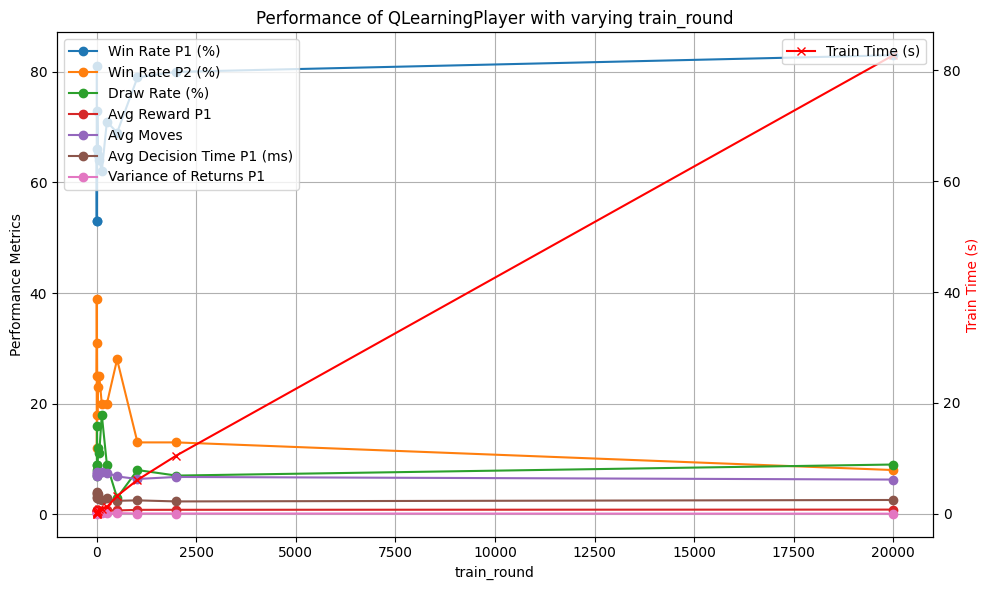

In [ ]:

# 核心运行和数据采集函数
def run_qlearning_experiment(alpha, gamma, epsilon, train_round, min_epsilon=0.01):
    # 初始化 Q-learning player 和游戏
    q_learning_player = QLearningPlayer('q-agent', alpha, epsilon, gamma)
    game = TicTacToe(q_learning_player, random_player_1)

    # 训练模型并记录训练时间
    start_time = time.time()
    game.train(rounds=train_round, min_epsilon=min_epsilon)
    train_time = time.time() - start_time

    # 保存策略
    q_learning_player.savePolicy()

    # 加载训练好的策略进行评估
    p1 = QLearningPlayer('p1', epsilon=0)  # epsilon=0 表示完全利用，不探索
    p1.loadPolicy('policy_q-agent')

    # 评估模型
    ttt = TicTacToe(q_learning_player, random_player_1)
    results_qlearning_vs_random = ttt.evaluate(rounds=100)

    # 返回结果字典
    return {
        'alpha': alpha,
        'gamma': gamma,
        'epsilon': epsilon,
        'train_round': train_round,
        'Train Time (s)': train_time,
        'Win Rate P1 (%)': results_qlearning_vs_random['Win Rate P1 (%)'],
        'Win Rate P2 (%)': results_qlearning_vs_random['Win Rate P2 (%)'],
        'Draw Rate (%)': results_qlearning_vs_random['Draw Rate (%)'],
        'Avg Reward P1': results_qlearning_vs_random['Avg Reward P1'],
        'Avg Moves': results_qlearning_vs_random['Avg Moves'],
        'Avg Decision Time P1 (ms)': results_qlearning_vs_random['Avg Decision Time P1 (ms)'],
        'Variance of Returns P1': results_qlearning_vs_random['Variance of Returns P1']
    }

# 绘制结果函数
def plot_results(df_results, param_name):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 左轴：绘制 Win Rate, Draw Rate, Avg Reward, Avg Moves, Avg Decision Time, Variance of Returns
    ax1.plot(df_results[param_name], df_results['Win Rate P1 (%)'], marker='o', label='Win Rate P1 (%)')
    ax1.plot(df_results[param_name], df_results['Win Rate P2 (%)'], marker='o', label='Win Rate P2 (%)')
    ax1.plot(df_results[param_name], df_results['Draw Rate (%)'], marker='o', label='Draw Rate (%)')
    ax1.plot(df_results[param_name], df_results['Avg Reward P1'], marker='o', label='Avg Reward P1')
    ax1.plot(df_results[param_name], df_results['Avg Moves'], marker='o', label='Avg Moves')
    ax1.plot(df_results[param_name], df_results['Avg Decision Time P1 (ms)'], marker='o', label='Avg Decision Time P1 (ms)')
    ax1.plot(df_results[param_name], df_results['Variance of Returns P1'], marker='o', label='Variance of Returns P1')

    # 添加图例和轴标签
    ax1.set_xlabel(param_name)
    ax1.set_ylabel('Performance Metrics')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # 右轴：绘制 Train Time
    ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
    ax2.plot(df_results[param_name], df_results['Train Time (s)'], marker='x', color='red', label='Train Time (s)')
    ax2.set_ylabel('Train Time (s)', color='red')
    ax2.legend(loc='upper right')

    # 显示图表
    plt.title(f'Performance of QLearningPlayer with varying {param_name}')
    plt.tight_layout()
    plt.show()

# 参数设置
train_rounds = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2000, 20000]  # 训练轮次 2000

# 比较不同的train_rounds
results_train_rounds = []
for train_round in train_rounds:
    results_train_rounds.append(run_qlearning_experiment(alpha=0.2, gamma=0.99, epsilon=0.3, train_round=train_round))

# 将train_rounds的结果转换为 DataFrame
df_train_rounds = pd.DataFrame(results_train_rounds)
print(df_train_rounds)

# 绘制train_rounds的结果
plot_results(df_train_rounds, 'train_round')

In [ ]:
alpha = 0.02
gamma = 0.8
epsilon = 0.2
train_round = 20000


# 初始化 Q-learning player 和游戏
q_learning_player = QLearningPlayer('q-agent', alpha, epsilon, gamma)

#random_player_1 = RandomPlayer(name="random1")

# 假设你在 1000 轮次的训练后，想要观察 Q 值的变化
q_learning_player.resetQValueChanges()  # 重置 Q 值变化记录
game = TicTacToe(q_learning_player, random_player_1)
game.train(rounds=train_round)

# 获取 Q 值变化记录
q_value_changes = q_learning_player.getQValueChanges()

# 绘制 Q 值变化趋势图
plt.plot(q_value_changes)
plt.xlabel('Training Iterations')
plt.ylabel('Q-Value Change')
plt.title('Q-Value Changes Over Time (Convergence)')
plt.show()


 53%|█████▎    | 10531/20000 [00:36<00:28, 327.78it/s]

In [ ]:

# 比较不同的alphas

alphas = [0.02, 0.04, 0.08, 0.16, 0.32, 0.64]  # 学习率 0.02
results_alphas = []
for alpha in alphas:
    results_alphas.append(run_qlearning_experiment(alpha=alpha, gamma=0.99, epsilon=0.3, train_round=2000))

# 将alphas的结果转换为 DataFrame
df_alphas = pd.DataFrame(results_alphas)
print(df_alphas)

# 绘制alphas的结果
plot_results(df_alphas, 'alpha')

In [ ]:

gammas = [0.2,0.4,0.6,0.8, 0.85, 0.9, 0.95]  # 折扣因子 0.8
# 比较不同的gammas
results_gammas = []
for gamma in gammas:
    results_gammas.append(run_qlearning_experiment(alpha=0.02, gamma=gamma, epsilon=0.3, train_round=2000))

# 将gammas的结果转换为 DataFrame
df_gammas = pd.DataFrame(results_gammas)
print(df_gammas)

# 绘制gammas的结果
plot_results(df_gammas, 'gamma')



In [ ]:

# 比较不同的epsilons

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]  # 探索率 0.2
results_epsilons = []
for epsilon in epsilons:
    results_epsilons.append(run_qlearning_experiment(alpha=0.02, gamma=0.8, epsilon=epsilon, train_round=2000))

# 将epsilons的结果转换为 DataFrame
df_epsilons = pd.DataFrame(results_epsilons)
print(df_epsilons)

# 绘制epsilons的结果
plot_results(df_epsilons, 'epsilon')

In [ ]:

# Minimax player and random player initialization
minimax_player = MinimaxPlayer(name="minimax", use_alpha_beta=True, max_depth=9)
minimax_player3 = MinimaxPlayer(name="minimax3", use_alpha_beta=True, max_depth=3)
minimax_player9 = MinimaxPlayer(name="minimax9", use_alpha_beta=True, max_depth=9)

random_player_1 = RandomPlayer(name="random1")

# Q-learning parameters
alpha = 0.02
gamma = 0.8
epsilon = 0.2
train_round = 2000

# Initialize Q-learning player and train it
q_learning_player = QLearningPlayer('q-agent', alpha, epsilon, gamma)
game = TicTacToe(q_learning_player, random_player_1)
game.train(rounds=train_round)

# Save Q-learning policy
q_learning_player.savePolicy()

# Load the trained Q-learning player for evaluation (fully exploit the learned policy)
p1 = QLearningPlayer('p1', epsilon=0)  # epsilon=0: no exploration, fully exploiting
p1.loadPolicy('policy_q-agent')

# Evaluate 1: MinimaxPlayer vs QLearningPlayer
ttt = TicTacToe(minimax_player, q_learning_player)
results_minimax_vs_qlearning = ttt.evaluate(rounds=100)

# Evaluate 2: MinimaxPlayer vs RandomPlayer
ttt = TicTacToe(minimax_player, random_player_1)
results_minimax_vs_random = ttt.evaluate(rounds=100)

# Evaluate 3: QLearningPlayer vs RandomPlayer
ttt = TicTacToe(q_learning_player, random_player_1)
results_qlearning_vs_random = ttt.evaluate(rounds=100)

# Evaluate 4: RandomPlayer vs RandomPlayer
ttt = TicTacToe(random_player_1, RandomPlayer(name="random2"))
results_random_vs_random = ttt.evaluate(rounds=100)

# Evaluate 5: minimax vs minimax2
ttt = TicTacToe(minimax_player, minimax_player3)
results_minimax_vs_minimax2 = ttt.evaluate(rounds=100)


ttt = TicTacToe(minimax_player, minimax_player3)
results_minimax_vs_minimax3 = ttt.evaluate(rounds=100)

ttt = TicTacToe(minimax_player, minimax_player9)
results_minimax_vs_minimax9= ttt.evaluate(rounds=100)

# Collect all results in a DataFrame
df_results = pd.DataFrame([
    results_minimax_vs_qlearning,
    results_minimax_vs_random,
    results_qlearning_vs_random,
    results_random_vs_random,
    results_minimax_vs_minimax3,
    results_minimax_vs_minimax9
])

df_results.columns = ['Win Rate P1 (%)', 'Win Rate P2 (%)', 'Draw Rate (%)',
                      'Avg Reward P1', 'Avg Reward P2', 'Avg Moves',
                      'Avg Decision Time P1 (ms)', 'Avg Decision Time P2 (ms)',
                      'Variance of Returns P1', 'Variance of Returns P2']


df_results.index = ['MinimaxPlayer vs QLearningPlayer',
                    'MinimaxPlayer vs RandomPlayer',
                    'QLearningPlayer vs RandomPlayer',
                    'RandomPlayer vs RandomPlayer',
                    'minimaxPlayer vs minimaxPlayer3',
                    'minimaxPlayer vs minimaxPlayer9']



df_results = df_results[['Win Rate P1 (%)', 'Win Rate P2 (%)', 'Draw Rate (%)']]

# Plotting the results with horizontal bars
ax = df_results.plot(kind='barh', figsize=(12, 8), color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Set title and labels
plt.title('Performance Comparison', fontsize=16)
plt.ylabel('Matchups', fontsize=12)
plt.xlabel('Metrics', fontsize=12)

# Move the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Metrics")

# Add grid lines to make it easier to compare metrics
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust the layout to fit the legend and labels
plt.tight_layout()

# Show the plot
plt.show()


* α（学习率）：0.1 到 0.3。选择较低的学习率，以防止 Q 值更新过度调整。
* ε（探索率）：开始时为 0.9（高探索率），随着时间逐渐衰减到 0.1 或更低。
* γ（折扣因子）：0.9 到 0.95。强调长期回报，关注赢得游戏的未来奖励。

## 3.3 Evaluation Metrix  

(win rate, average reward, training time,convergence rate, and decision time)

# **Step 4. Random Algorithm**

## 4.1 Algorithm Description

explain something

In [ ]:
# Algorithm Implement
class RandomAgent:
    def choose_action(self, state):
        return random.choice(available_actions)


## 4.2 Parameters Analysis

### 4.2.1 Parameter1 change Analysis

In [ ]:

# Define a function to evaluate the model (todo)

# List of parameter1 to test
parameter_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
results = []

#evaluate_model with different parameter

for lr in parameter_list:
    result = evaluate_model(lr)
    results.append((result))

# Convert results to a DataFrame for better visualization

# Highlight the best learning rate
best_lr = results_df.loc[results_df['MSE'].idxmin()]
print("The best learning rate is: ", best_lr['Learning Rate'])
print(f"Results for the best learning rate ({best_lr['Learning Rate']}):")
print(f"MSE: {best_lr['MSE']}")
print(f"RMSE: {best_lr['RMSE']}")
print(f"MAE: {best_lr['MAE']}")
print(f"R²: {best_lr['R²']}")

# Display the results
print(results_df)

My_Learning_Rate = best_lr['Learning Rate']


**Show Plt**

In [ ]:

if CALCU_HYPER_PARAMETERS:
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Learning Rate'], results_df['MSE'], label='MSE')
    plt.plot(results_df['Learning Rate'], results_df['RMSE'], label='RMSE')
    plt.plot(results_df['Learning Rate'], results_df['MAE'], label='MAE')
    plt.xlabel('Learning Rate')
    plt.ylabel('Error')
    plt.title('Error Metrics vs Learning Rate')
    plt.legend()
    plt.xscale('log')  # To better visualize the differences across learning rates
    plt.show()

## 4.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 5. Minimax Algorithm**

## 5.1 Algorithm Description

explain something

In [ ]:
# Algorithm Implement

def minimax(state, depth, is_maximizing):
    # Minimax algorithm implementation
    pass

def alpha_beta(state, depth, alpha, beta, is_maximizing):
    # Alpha-beta pruning optimization of Minimax
    pass



## 5.2 Parameters Analysis

### 5.2.1 Parameter1 change Analysis

In [ ]:

# Define a function to evaluate the model (todo)

# List of parameter1 to test
parameter_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
results = []

#evaluate_model with different parameter

for lr in parameter_list:
    result = evaluate_model(lr)
    results.append((result))

# Convert results to a DataFrame for better visualization

# Highlight the best learning rate
best_lr = results_df.loc[results_df['MSE'].idxmin()]
print("The best learning rate is: ", best_lr['Learning Rate'])
print(f"Results for the best learning rate ({best_lr['Learning Rate']}):")
print(f"MSE: {best_lr['MSE']}")
print(f"RMSE: {best_lr['RMSE']}")
print(f"MAE: {best_lr['MAE']}")
print(f"R²: {best_lr['R²']}")

# Display the results
print(results_df)

My_Learning_Rate = best_lr['Learning Rate']


**Show Plt**

In [ ]:

if CALCU_HYPER_PARAMETERS:
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Learning Rate'], results_df['MSE'], label='MSE')
    plt.plot(results_df['Learning Rate'], results_df['RMSE'], label='RMSE')
    plt.plot(results_df['Learning Rate'], results_df['MAE'], label='MAE')
    plt.xlabel('Learning Rate')
    plt.ylabel('Error')
    plt.title('Error Metrics vs Learning Rate')
    plt.legend()
    plt.xscale('log')  # To better visualize the differences across learning rates
    plt.show()

## 5.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 6. Alpha-beta Algorithm**

## 6.1 Algorithm Description

explain something

In [ ]:
# Algorithm Implement

def alpha_beta(state, depth, alpha, beta, is_maximizing):
    # Alpha-beta pruning optimization of Minimax
    pass



## 5.2 Parameters Analysis

### 5.2.1 Parameter1 change Analysis

In [ ]:

# Define a function to evaluate the model (todo)

# List of parameter1 to test
parameter_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
results = []

#evaluate_model with different parameter

for lr in parameter_list:
    result = evaluate_model(lr)
    results.append((result))

# Convert results to a DataFrame for better visualization

# Highlight the best learning rate
best_lr = results_df.loc[results_df['MSE'].idxmin()]
print("The best learning rate is: ", best_lr['Learning Rate'])
print(f"Results for the best learning rate ({best_lr['Learning Rate']}):")
print(f"MSE: {best_lr['MSE']}")
print(f"RMSE: {best_lr['RMSE']}")
print(f"MAE: {best_lr['MAE']}")
print(f"R²: {best_lr['R²']}")

# Display the results
print(results_df)

My_Learning_Rate = best_lr['Learning Rate']


**Show Plt**

In [ ]:

if CALCU_HYPER_PARAMETERS:
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Learning Rate'], results_df['MSE'], label='MSE')
    plt.plot(results_df['Learning Rate'], results_df['RMSE'], label='RMSE')
    plt.plot(results_df['Learning Rate'], results_df['MAE'], label='MAE')
    plt.xlabel('Learning Rate')
    plt.ylabel('Error')
    plt.title('Error Metrics vs Learning Rate')
    plt.legend()
    plt.xscale('log')  # To better visualize the differences across learning rates
    plt.show()

## 5.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 7. MCTS Algorithm**

## 7.1 Algorithm Description

explain something

In [ ]:
# Algorithm Implement



# Monte Carlo Tree Search (MCTS) Player
class MCTSPlayer:
    def __init__(self, player_num, simulations=100):
        self.player_num = player_num
        self.opponent_num = 1 if player_num == 2 else 2
        self.simulations = simulations

    def rollout(self, game):
        current_player = self.player_num
        while True:
            if game.is_winner(self.player_num):
                return 1
            if game.is_winner(self.opponent_num):
                return -1
            if game.is_draw():
                return 0
            row, col = random.choice(game.get_empty_positions())
            game.make_move(row, col, current_player)
            current_player = 1 if current_player == 2 else 2

    def move(self, game):
        best_move = None
        best_score = -float('inf')

        for row, col in game.get_empty_positions():
            score = 0
            for _ in range(self.simulations):
                game_copy = TicTacToe()
                game_copy.board = game.board.copy()
                game_copy.make_move(row, col, self.player_num)
                score += self.rollout(game_copy)
            if score > best_score:
                best_score = score
                best_move = (row, col)
        return best_move




## 5.2 Parameters Analysis

### 5.2.1 Parameter1 change Analysis

In [ ]:

# Define a function to evaluate the model (todo)

# List of parameter1 to test
parameter_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
results = []

#evaluate_model with different parameter

for lr in parameter_list:
    result = evaluate_model(lr)
    results.append((result))

# Convert results to a DataFrame for better visualization

# Highlight the best learning rate
best_lr = results_df.loc[results_df['MSE'].idxmin()]
print("The best learning rate is: ", best_lr['Learning Rate'])
print(f"Results for the best learning rate ({best_lr['Learning Rate']}):")
print(f"MSE: {best_lr['MSE']}")
print(f"RMSE: {best_lr['RMSE']}")
print(f"MAE: {best_lr['MAE']}")
print(f"R²: {best_lr['R²']}")

# Display the results
print(results_df)

My_Learning_Rate = best_lr['Learning Rate']


**Show Plt**

In [ ]:

if CALCU_HYPER_PARAMETERS:
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Learning Rate'], results_df['MSE'], label='MSE')
    plt.plot(results_df['Learning Rate'], results_df['RMSE'], label='RMSE')
    plt.plot(results_df['Learning Rate'], results_df['MAE'], label='MAE')
    plt.xlabel('Learning Rate')
    plt.ylabel('Error')
    plt.title('Error Metrics vs Learning Rate')
    plt.legend()
    plt.xscale('log')  # To better visualize the differences across learning rates
    plt.show()

## 5.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 8. Q-learning Algorithm**

## 8.1 Algorithm Description

explain something

In [ ]:



# Q-learning player
class QLearningPlayer:
    # Global static variable to save the Q-table
    q_table_global = {}

    def __init__(self, player_num, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.player_num = player_num
        self.opponent_num = 1 if player_num == 2 else 2
        self.q_table = QLearningPlayer.q_table_global  # Use the global Q-table
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.previous_state = None
        self.previous_action = None

    def get_state(self, game):
        return str(game.board.reshape(9))

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0)

    def choose_action(self, game):
        state = self.get_state(game)
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(game.get_empty_positions())
        else:
            q_values = []
            actions = game.get_empty_positions()
            for action in actions:
                q_values.append(self.get_q_value(state, action))
            max_q = max(q_values)
            max_actions = [action for action, q in zip(actions, q_values) if q == max_q]
            return random.choice(max_actions)

    def update_q_table(self, reward, next_game_state, terminal):
        if self.previous_state is not None and self.previous_action is not None:
            if terminal:
                best_future_q = 0
            else:
                next_state = self.get_state(next_game_state)
                possible_actions = next_game_state.get_empty_positions()
                best_future_q = max([self.get_q_value(next_state, action) for action in possible_actions], default=0)
            old_q_value = self.get_q_value(self.previous_state, self.previous_action)
            self.q_table[(self.previous_state, self.previous_action)] = old_q_value + \
                self.alpha * (reward + self.gamma * best_future_q - old_q_value)
            if terminal:
                self.previous_state = None
                self.previous_action = None
            else:
                self.previous_state = next_state
                self.previous_action = None  # Will be set in next move

    def move(self, game):
        state = self.get_state(game)
        action = self.choose_action(game)
        # Store previous state and action
        self.previous_state = state
        self.previous_action = action
        return action

    # Save the Q-table to the class's static variable
    @classmethod
    def save_q_table(cls, instance):
        cls.q_table_global = instance.q_table  # Update the global Q-table with the instance's Q-table



In [ ]:
# Evaluation Method
Metrics to be evaluated:
- Win rate over multiple games
- Decision-making speed (time taken per move)
- Average cumulative reward

## 5.2 Parameters Analysis

### 5.2.1 Parameter1 change Analysis

In [ ]:

# Define a function to evaluate the model (todo)

# List of parameter1 to test
parameter_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
results = []

#evaluate_model with different parameter

for lr in parameter_list:
    result = evaluate_model(lr)
    results.append((result))

# Convert results to a DataFrame for better visualization

# Highlight the best learning rate
best_lr = results_df.loc[results_df['MSE'].idxmin()]
print("The best learning rate is: ", best_lr['Learning Rate'])
print(f"Results for the best learning rate ({best_lr['Learning Rate']}):")
print(f"MSE: {best_lr['MSE']}")
print(f"RMSE: {best_lr['RMSE']}")
print(f"MAE: {best_lr['MAE']}")
print(f"R²: {best_lr['R²']}")

# Display the results
print(results_df)

My_Learning_Rate = best_lr['Learning Rate']


**Show Plt**

In [ ]:

if CALCU_HYPER_PARAMETERS:
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Learning Rate'], results_df['MSE'], label='MSE')
    plt.plot(results_df['Learning Rate'], results_df['RMSE'], label='RMSE')
    plt.plot(results_df['Learning Rate'], results_df['MAE'], label='MAE')
    plt.xlabel('Learning Rate')
    plt.ylabel('Error')
    plt.title('Error Metrics vs Learning Rate')
    plt.legend()
    plt.xscale('log')  # To better visualize the differences across learning rates
    plt.show()

## 5.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 9. DQN Algorithm**

## 9.1 Algorithm Description

explain something

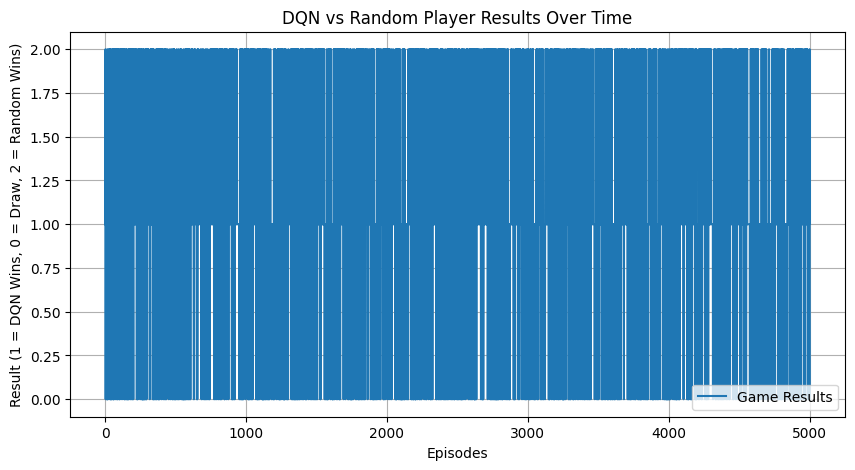

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

class RandomPlayer:
    def __init__(self, player_num):
        self.player_num = player_num

    def move(self, game):
        return random.choice(game.get_empty_positions())

# Tic-Tac-Toe board class
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)

    def reset(self):
        self.board.fill(0)

    def make_move(self, row, col, player):
        if self.board[row, col] == 0:
            self.board[row, col] = player
            return True
        return False

    def is_winner(self, player):
        for row in range(3):
            if np.all(self.board[row, :] == player):
                return True
        for col in range(3):
            if np.all(self.board[:, col] == player):
                return True
        if self.board[0, 0] == player and self.board[1, 1] == player and self.board[2, 2] == player:
            return True
        if self.board[0, 2] == player and self.board[1, 1] == player and self.board[2, 0] == player:
            return True
        return False

    def is_draw(self):
        return np.all(self.board != 0)

    def get_empty_positions(self):
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]

    def print_board(self):
        print(self.board)

# Define the DQN neural network
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 9)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Output is Q-values for each action

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Deep Q-Network (DQN) Player
class DQNPlayer:
    def __init__(self, player_num, epsilon=0.1, gamma=0.9, batch_size=32, memory_capacity=1000, learning_rate=0.001):
        self.player_num = player_num
        self.opponent_num = 1 if player_num == 2 else 2
        self.model = DQN()
        self.target_model = DQN()
        self.target_model.load_state_dict(self.model.state_dict())  # Initialize target model with the same weights
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.memory = ReplayMemory(memory_capacity)
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.update_target_steps = 100  # Update the target model every 100 steps
        self.steps_done = 0

    def get_state(self, game):
        return torch.FloatTensor(game.board.reshape(9))

    def choose_action(self, game):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(game.get_empty_positions())  # Exploration
        else:
            state = self.get_state(game).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state)
            valid_moves = game.get_empty_positions()
            valid_q_values = [q_values[0, i * 3 + j].item() for i, j in valid_moves]
            max_q_value = max(valid_q_values)
            return valid_moves[valid_q_values.index(max_q_value)]  # Exploitation

    def store_memory(self, game, action, reward, next_game, done):
        state = self.get_state(game)
        next_state = self.get_state(next_game)
        self.memory.push(state, action, reward, next_state, done)

    def train_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)
        for state, action, reward, next_state, done in batch:
            q_values = self.model(state)
            q_target = q_values.clone().detach()
            next_q_values = self.target_model(next_state)
            max_next_q = torch.max(next_q_values).item()

            if done:
                target_value = reward
            else:
                target_value = reward + self.gamma * max_next_q

            q_target[0, action] = target_value
            self.optimizer.zero_grad()
            loss = self.loss_fn(q_values, q_target)
            loss.backward()
            self.optimizer.step()

        self.steps_done += 1
        if self.steps_done % self.update_target_steps == 0:
            self.target_model.load_state_dict(self.model.state_dict())  # Update target model

    def move(self, game):
        action = self.choose_action(game)
        return action

# Play a match
def play_game(player1, player2, game):
    game.reset()
    current_player = player1
    next_player = player2
    while True:
        row, col = current_player.move(game)
        game.make_move(row, col, current_player.player_num)
        if game.is_winner(current_player.player_num):
            return current_player.player_num
        if game.is_draw():
            return 0
        current_player, next_player = next_player, current_player

# Now rerun the main part to train the DQN player and plot the results
if __name__ == '__main__':
    game = TicTacToe()
    dqn_player = DQNPlayer(1)
    random_player = RandomPlayer(2)

    # Store results for plotting
    results = []

    # Simulate training over multiple games
    episodes = 5000  # Number of games to play
    for episode in range(episodes):
        result = play_game(dqn_player, random_player, game)
        results.append(result)  # Store the result for plotting
        dqn_player.train_model()

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, episodes + 1), results, label='Game Results')
    plt.xlabel('Episodes')
    plt.ylabel('Result (1 = DQN Wins, 0 = Draw, 2 = Random Wins)')
    plt.title('DQN vs Random Player Results Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


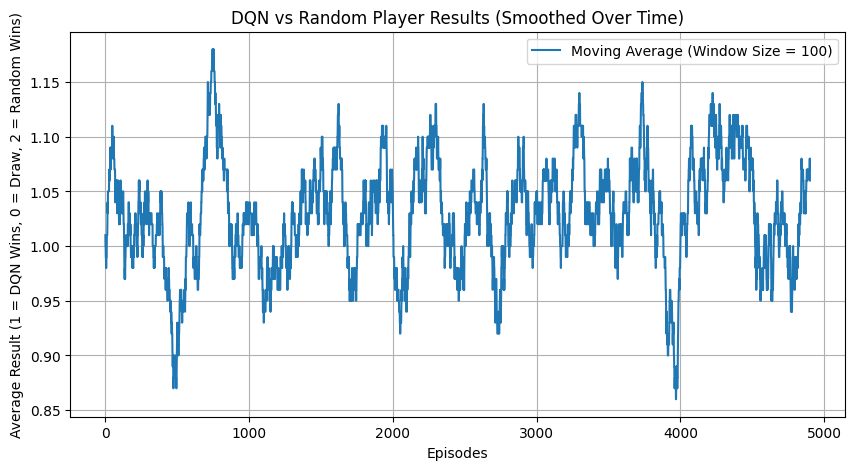

In [3]:
# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average with a window size of 100 episodes
window_size = 100
smoothed_results = moving_average(results, window_size)

# Plotting the smoothed results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(smoothed_results) + 1), smoothed_results, label=f'Moving Average (Window Size = {window_size})')
plt.xlabel('Episodes')
plt.ylabel('Average Result (1 = DQN Wins, 0 = Draw, 2 = Random Wins)')
plt.title('DQN vs Random Player Results (Smoothed Over Time)')
plt.legend()
plt.grid(True)
plt.show()

## 5.2 Parameters Analysis

### 5.2.1 Parameter1 change Analysis

## 5.3 Conclusion

Analyze how changing parameters impacted the performance of agent

# **Step 10. Discussion and Analysis**

## 10.1 Visual Performance comparision
Use graphs and tables to compare the performance of different algorithms. Show win rates, decision time, and convergence rate.

In [ ]:

# Define the best hyperparameters

# LSTM Replace with the best hyperparameters found
best_epoch = 200
best_batch_size = 64
best_neuron_count = 8

# MLP Replace with the best hyperparameters found
neurons_layer1 = 12
neurons_layer2 = 13
learning_rate = 0.1

# Create and train the MLP model
def train_mlp(X_train, y_train, X_test, y_test, neurons_layer1, neurons_layer2, learning_rate):
    mlp = MLPRegressor(hidden_layer_sizes=(neurons_layer1, neurons_layer2), learning_rate_init=learning_rate, max_iter=1000, random_state=42)
    mlp.fit(X_train, y_train)
    mlp_predictions = mlp.predict(X_test)
    mlp_predictions_actual = inverse_transform_predictions(mlp_predictions, my_scaler, X_test)
    y_test_actual = inverse_transform_predictions(y_test, my_scaler, X_test)
    return mlp, mlp_predictions_actual, y_test_actual

# Create and train the LSTM model
def train_lstm(X_train, y_train, X_test, y_test, epochs, batch_size, neuron_count):
    model = build_custom_lstm_model(input_shape_custom=my_input_shape, neurons_num=neuron_count)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    lstm_predictions = model.predict(X_test)
    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of lstm_predictions:", lstm_predictions.shape)
    print("Shape of lstm_predictions:", lstm_predictions)
    lstm_predictions_actual = inverse_transform_predictions(lstm_predictions, my_scaler, X_test)
    y_test_actual = inverse_transform_predictions(y_test, my_scaler, X_test)
    return model, lstm_predictions_actual, y_test_actual

# Function to calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return mse, rmse, mae, r2

# Function to plot performance metrics
def plot_metrics(y_test_actual, mlp_predictions_actual, lstm_predictions_actual, time_test):
    plt.figure(figsize=(14, 7))
    plt.plot(time_test, y_test_actual, label='Actual PM2.5', color='blue')
    plt.plot(time_test, mlp_predictions_actual, label='Predicted PM2.5 (MLP)', color='orange', alpha=0.7)
    plt.plot(time_test, lstm_predictions_actual, label='Predicted PM2.5 (LSTM)', color='green', alpha=0.7)
    plt.title('PM2.5 Real and Prediction Values in MLP and LSTM')
    plt.xlabel('Time')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to plot comparison bar charts
def plot_comparison_bar_chart(mlp_metrics, lstm_metrics):
    labels = ['RMSE', 'MAE', 'R²']
    x = np.arange(len(labels))  # Number of metrics
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, mlp_metrics, width, label='MLP')
    rects2 = ax.bar(x + width/2, lstm_metrics, width, label='LSTM')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison of MLP and LSTM')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

# Inverse transform function
def inverse_transform_predictions(predictions, scaler, X_data):
    predictions_flat = predictions.reshape(-1, 1)
    zeros_shape = (predictions_flat.shape[0], X_data.shape[1]) if X_data.ndim == 2 else (predictions_flat.shape[0], X_data.shape[2])
    predictions_actual_flat = scaler.inverse_transform(np.concatenate([np.zeros(zeros_shape), predictions_flat], axis=1))[:, -1]
    predictions_actual = predictions_actual_flat.reshape(predictions.shape)
    return predictions_actual

train_size = int(len(X_scaler) * 0.7)
X_train, X_test = X_scaler[:train_size], X_scaler[train_size:]
y_train, y_test = y_scaler[:train_size], y_scaler[train_size:]

time_test = df.index[train_size + N_STEPS:]

mlp, mlp_predictions_actual, y_test_actual = train_mlp(X_train, y_train, X_test, y_test, neurons_layer1, neurons_layer2, learning_rate)
model, lstm_predictions_actual, y_test_lstm_actual = train_lstm(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, best_epoch, best_batch_size, best_neuron_count)


In [ ]:
# Plotting win rates of different agents
plt.plot(episodes, q_learning_win_rates, label='Q-learning')
plt.plot(episodes, dqn_win_rates, label='DQN')
plt.plot(episodes, minimax_win_rates, label='Minimax')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Win Rate')
plt.show()

In [ ]:

# Calculate metrics
mlp_mse, mlp_rmse, mlp_mae, mlp_r2 = calculate_metrics(y_test_actual, mlp_predictions_actual)
lstm_mse, lstm_rmse, lstm_mae, lstm_r2 = calculate_metrics(y_test_lstm_actual, lstm_predictions_actual)

# Plot actual and predicted PM2.5 values
plot_metrics(y_test_actual[N_STEPS:], mlp_predictions_actual[N_STEPS:], lstm_predictions_actual, time_test)

# Plot performance metrics comparison
plot_comparison_bar_chart([mlp_rmse, mlp_mae, mlp_r2], [lstm_rmse, lstm_mae, lstm_r2])

# Print performance metrics for MLP
print("MLP Performance:")
print(f"RMSE: {mlp_rmse}")
print(f"MAE: {mlp_mae}")
print(f"R²: {mlp_r2}")

# Print performance metrics for LSTM
print("\nLSTM Performance:")
print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R²: {lstm_r2}")

# Print model summaries
print("\nMLP Model Summary:")
print(f"Hidden Layers: {mlp.hidden_layer_sizes}")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Learning rate: {mlp.learning_rate_init}")

print("\nLSTM Model Summary:")
model.summary()

## 10.2 Compare the strengths and weaknesses of RL (e.g., Q-learning, DQN) vs. planning algorithms (Minimax, MCTS).

# 11. Conclusion

在井字棋（Tic-Tac-Toe）游戏中，最有效的算法通常是 **极大极小算法（Minimax）**，特别是当结合了 **alpha-beta 剪枝** 优化时。原因在于井字棋的状态空间相对较小，可以通过穷举所有可能的棋盘状态，计算出最佳的策略，从而实现完美的游戏（即在双方都采取最佳策略时，游戏总是以平局结束）。

**为什么极大极小算法表现最佳？**

- **完整性**：极大极小算法通过递归地评估所有可能的棋盘状态，确保找到最优的行动序列。
- **可行性**：由于井字棋的状态空间有限（约有 5478 个可能的合法状态），使用极大极小算法在计算上是可行的。
- **确定性**：该算法不依赖于概率或统计，结果是确定性的，可预测的。

**Q-learning 和其他强化学习方法的表现**

- **学习过程**：Q-learning 等强化学习算法需要通过大量的训练，与环境反复交互，才能逐步学到接近最优的策略。
- **收敛速度**：由于井字棋的状态空间虽然有限但仍然较大，强化学习算法可能需要相当多的训练回合才能收敛到最优策略。
- **不确定性**：强化学习的结果可能受到超参数设置、初始条件和训练过程的随机性的影响，无法保证一定达到最优策略。

**比较总结**

- **极大极小算法**
  - **优势**：能保证找到最优策略；适用于小型、确定性的游戏。
  - **劣势**：对于大型或复杂游戏，计算量会呈指数增长，难以实现。

- **Q-learning 和强化学习**
  - **优势**：适用于大型、复杂的游戏环境，能通过学习应对未知的环境和对手策略。
  - **劣势**：在小型游戏中，学习过程可能效率较低，无法保证找到最优策略。

**结论**

在井字棋中，**极大极小算法** 通常是表现最好的算法，能够实现完美的游戏策略。**Q-learning** 和其他强化学习方法虽然在理论上也能学习到较好的策略，但在井字棋这种简单游戏中，它们的效率和效果不如极大极小算法。

**建议**

- **简单游戏**：对于井字棋等简单游戏，使用搜索算法（如极大极小算法）更为有效。
- **复杂游戏**：对于状态空间巨大、无法穷举的复杂游戏（如围棋、国际象棋），强化学习方法（尤其是深度强化学习）更为适用。

**扩展思考**

- 如果您的目标是研究强化学习算法，可以尝试在更复杂的游戏环境中应用，如 **Connect Four（四子棋）**、**Snake（贪吃蛇）** 或自定义的策略游戏。
- 在井字棋中，您也可以通过改进状态表示、奖励函数和训练策略，提升 Q-learning 的学习效率，但总体上其表现仍难以超越极大极小算法。

# 12. References